# Домашнее Задание 3: Нейронные сети 

In [462]:
### Ваше имя: Denis Sosnovskiy

## Загружаем библиотеки

In [463]:
import numpy as np
import pandas as pd
import requests
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.optim as optim
import torch
from torchvision import datasets, transforms

## Загружаем и анализируем датасет о предсказании "Churn", т.е. отказа от услуг (когда клиент перестает быть клиентом)

In [464]:
# https://en.wikipedia.org/wiki/Churn_rate
data_file = "Telco_customer_churn_2020.csv"
df = pd.read_csv(data_file, encoding = "utf-8" , engine='python')

print(df.columns)
print(df.shape)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')
(7043, 33)


### Обработайте датасет как в 1м задании ( можно просто взять код оттуда)

In [465]:
from pandas.api.types import is_numeric_dtype
# Оставить только числа (убрать все не цифровые столбци)
num_col = [col for col in df.columns if is_numeric_dtype(df[col])]
df = df[num_col]

# выбрать лучшие фичи для предсказания 
for col in df.columns:
    print('The correlation between', col, 'and Churn Value: ', df[col].corr(df['Churn Value']))
    
DF = pd.concat([df['CLTV'],df['Monthly Charges'],df['Tenure Months'],df["Churn Score"],df['Churn Value']],axis=1)
DF #I've chosen all |correlations| > 0.1, they are sorted from minimal to maximal |corr value| (from left to right)    
print('\n')

# Найти и убрать outlier
for col in DF.columns:
    print('Outliers = ',DF[col][np.abs((DF[col]-DF[col].mean())/DF[col].std()) > 3]) # there are no any outliers; 

# Нормализировать данные
for col in DF.columns:
    if col!='Churn Value':
        DF[col] = stats.zscore(DF[col])
        
#DF_x = DF.drop('Churn Value', axis=1)
#x_data = DF_x.values
#y_data = np.expand_dims(DF['Churn Value'].values, axis=1)
#y_data = DF['Churn Value'].values

x_data = np.array([DF['CLTV'],DF['Monthly Charges'],DF['Tenure Months'],DF["Churn Score"]]).transpose()
y_data = np.expand_dims(DF["Churn Value"], axis=1)

The correlation between Count and Churn Value:  nan
The correlation between Zip Code and Churn Value:  0.0033464802711836786
The correlation between Latitude and Churn Value:  -0.0033844365616311997
The correlation between Longitude and Churn Value:  0.004593811469422537
The correlation between Tenure Months and Churn Value:  -0.3522286701130772
The correlation between Monthly Charges and Churn Value:  0.19335642223784674
The correlation between Churn Value and Churn Value:  1.0
The correlation between Churn Score and Churn Value:  0.6648970311816232
The correlation between CLTV and Churn Value:  -0.1274631017174495


Outliers =  Series([], Name: CLTV, dtype: int64)
Outliers =  Series([], Name: Monthly Charges, dtype: float64)
Outliers =  Series([], Name: Tenure Months, dtype: int64)
Outliers =  Series([], Name: Churn Score, dtype: int64)
Outliers =  Series([], Name: Churn Value, dtype: int64)


# Применить все три метода на данном датасете

### Разделить датасет на ТРИ части: трен., утвержд. и тестовую

In [466]:
# 10% данных будем использовать как validation dataset
# 10% данных будем использовать как test dataset
split_size = 0.1

X_train_val, X_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=split_size, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split_size, shuffle=False)

print("\nShape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))

print("\nShape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

print("\nShape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))


Shape of features in training data: (5704, 4)
Shape of output in training data: (5704, 1)

Shape of features in val data: (634, 4)
Shape of output in val data: (634, 1)

Shape of features in test data: (705, 4)
Shape of output in test data: (705, 1)


## Задание 1: Применить нейронную сеть (20 балов)

In [467]:
# определить Dataset и DataLoader
class Dataset(torch.utils.data.Dataset):
  def __init__(self, inp, out):
        self.inp = inp
        self.out = out

  def __len__(self):
        return len(self.inp)

  def __getitem__(self, index):
        # Select sample
        input_ = self.inp[index]
        output_ = self.out[index]

        return input_, output_
    
training_set = Dataset(X_train, y_train)

batch_size = 100
training_generator = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=batch_size, drop_last=True)

Loss:   0%|          | 0/10 [00:00<?, ?it/s]

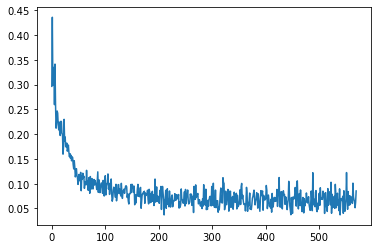

In [468]:
# определить структуру нейронной сети
model = nn.Sequential(
        nn.Linear(4,2),
        nn.Tanh(),
        nn.Linear(2,1)
)


# определить функцию ошибки, скорость апдейтов модели и способ оптимизации
learning_rate = 1e-2
optimiz = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()


# тренировать сетку на датасете
num_ep = 10
# Определим очередь (для компактной визуализации)
epochs_tdqm = tqdm(range(num_ep), desc="Loss")
# Будем сохранять ошибки
total_loss = [] 
# собственно цикл тренировки
for epoch in epochs_tdqm:

    #пройдемся по всем батчам из датасета
    for minibatch, labels in training_generator:
    
        minibatch = minibatch.float()
        
        # обнулим градиент
        model.zero_grad()
        
        # forward path: сделаем прогноз
        prediction = model(minibatch)
        
        # backward pass: посчитаем ошибку
        loss = loss_function(prediction, labels.float())
        loss.backward()
        optimiz.step()
        
        # сохраним ошибку
        epochs_tdqm.set_description("(Loss=%g)" % round(loss.item(), 4))
        total_loss.append(loss.detach().numpy())
        
plt.plot(total_loss)
plt.show()

In [469]:
# определить хорошие гипер-параметры сети 
# (скорось апдейтов модели, количество слоев и нейроном, размер батча и т.д.)

#finally I stopped with batch_size = 100, larning rate = 0.01, number of epoches = 10 and 
#structure of the model is 4 linear 2 --> tanh --> 2 linear 1

#with good paramaters we should obtain loss function coming to stationary conditions (see graph above) 

#and also to have minimal overfitting, in order to check this, we need to calculate and compare f1_score 
#for validation and training datasets

In [470]:
# Определим утверждающую выборку
val_set = Dataset(X_val, y_val)
validation_generator = torch.utils.data.DataLoader(val_set,shuffle=True, batch_size=batch_size, drop_last=True)

X_v = torch.tensor(X_val)

# Применяем на утверждающей выборке
y_pred = model(X_v.float()).detach().numpy()
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()
#print(y_pred)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print('f1_score on the validation data: %.2f'
      % f1_score(y_val, y_pred, average = 'macro'))

# Применяем на тренировочной выборке
X_t = torch.tensor(X_train)
y_pred = model(X_t.float()).detach().numpy()
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()

print('f1_score on the train data: %.2f'
      % f1_score(y_train, y_pred, average = 'macro'))

f1_score on the validation data: 0.48
f1_score on the train data: 0.89


Overfitting is taking place but still not really bad result. Let's calculate f1_score for the test data

In [471]:
# оценить на ТЕСТовой выборке

test_set = Dataset(X_test, y_test)
test_generator = torch.utils.data.DataLoader(test_set)
X_test = torch.tensor(X_test)
y_pred = model(X_test.float()).detach().numpy()
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()

print('f1_score on the test data: %.2f'
      % f1_score(y_test, y_pred,average = 'macro'))

f1_score on the test data: 0.48


Not bad result. Let's compate this with the best f1-scores in other methods. 

## Задание 2: оценить регрессию и метод К-ближайших соседей (15 балов)

In [472]:
# оценить остальные методы на ТЕСТовой выборке (используя параметры, которые вы раньше подобрали на утверждающей выборке)

# polynomial regression 
deg=[]
f1=[]

for i in range(1,15):
    deg.append(i)
    polyreg = make_pipeline(
        PolynomialFeatures(degree=i),
        LinearRegression()
        ) 
    polyreg.fit(X_train, y_train)
    y_pred = polyreg.predict(X_val)
    y_pred = np.clip(y_pred, 0, 1)
    y_pred = y_pred.round()
    f1.append(f1_score(y_val, y_pred,average = 'macro'))
    #print(f1_score(y_val, y_pred))
    
new_df = pd.DataFrame() #save metric in df
new_df['deg'] = deg
new_df['f1'] = f1
new_df[new_df['f1']==new_df['f1'].max()]

deg        f1
1    2  0.488297

So, the best f1_score is for polynomial degree = 2. Let's find f1_score on the test data.

In [473]:
polyreg = make_pipeline(
        PolynomialFeatures(degree=2),
        LinearRegression()
        ) 
polyreg.fit(X_train, y_train)
y_pred = polyreg.predict(X_test)
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()
print(f1_score(y_test, y_pred,average = 'macro'))

0.4880174291938998


f1_score calculated on the test data for polynomial regression is 0.488

In [474]:
# K-nearest neighbors 
K=[]
f1=[]

for i in range(1,30):
    K.append(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_val)
    y_pred = np.clip(y_pred, 0, 1)
    y_pred = y_pred.round()
    f1.append(f1_score(y_val, y_pred,average = 'macro'))
    #print(f1_score(y_val, y_pred))
    
new_df = pd.DataFrame() #save metric in df
new_df['K'] = K
new_df['f1'] = f1
new_df[new_df['f1']==new_df['f1'].max()]

K        f1
1  2  0.490354

K=2 is the best parameter value. 

In [475]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, np.ravel(y_train))
y_pred = knn.predict(X_test)
y_pred = np.clip(y_pred, 0, 1)
y_pred = y_pred.round()
print(f1_score(y_test, y_pred,average = 'macro'))

0.49060693641618497


f1_score calculated on the test data for k neighbors is 0.49

In [476]:
# какой из 3х методов дал лучший результат? Почему?

the difference between the results are negligible in my case due to the absence of any specificity in the dataset (not big, not small, no any gaps in the data, no outliers)

## Задание 3 : Применить все три метода на новом датасете (20 балов)

#### Step 1. Preparation

In [477]:
# загрузить новый датасет (можно взять из классных занятий)
date_start = '2015-01-01'
date_end = '2019-05-18'
area = 'STH'
url_base = 'https://mimer.svk.se/'
url_target = 'ConsumptionProfile/DownloadText?groupByType=0&' + \
             'periodFrom='+date_start+'&' + \
             'periodTo='+date_end+'&' + \
             'networkAreaIdString='+area
url = url_base+url_target
df = pd.read_csv(url, sep=';', header=1, decimal=',', usecols=[0,1], names=['Datetime', 'Load'])
df = df[:-1]
df.index = pd.to_datetime(df['Datetime'])
df = df.drop(columns='Datetime')
df['Load'] = -df['Load']/10**3


location = ('Stockholm A', 98230)
url = 'http://opendata-download-metobs.smhi.se/api/version/1.0/parameter/1/station/' + str(location[1]) + '/period/corrected-archive/data.csv'
r = requests.get(url)
decoded_content = r.content.decode('utf-8')
data = list(csv.reader(decoded_content.splitlines(), delimiter=';'))
header = 10
datetime = []
values = []
for d in data[header:]:
    datetime.append(d[0]+' '+d[1])
    values.append(float(d[2]))
df_temp = pd.DataFrame(data=values, index=pd.to_datetime(datetime), columns=['Temperature'])


df = pd.concat([df, df_temp*10], axis=1).dropna()
df = df['2015':]
df.head()


Load  Temperature
2015-01-01 01:00:00  306.556081         36.0
2015-01-01 02:00:00  292.298598         30.0
2015-01-01 03:00:00  281.169992         28.0
2015-01-01 04:00:00  272.705482         28.0
2015-01-01 05:00:00  268.873646         27.0

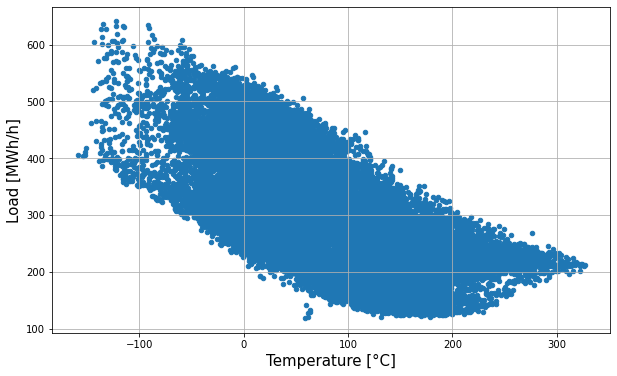

In [478]:
df.plot.scatter('Temperature', 'Load', figsize=(10,6))
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Load [MWh/h]', fontsize=15)
plt.grid()

In [479]:
#only numeric data
num_col = [col for col in df.columns if is_numeric_dtype(df[col])]
df = df[num_col]
      
x_data = np.array([df['Temperature']]).transpose()
y_data = np.expand_dims(df["Load"], axis=1)

In [480]:
# Не забудьте разделить датасет на ТРИ части: трен., утвержд. и тестовую
split_size = 0.1

X_train_val, X_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=split_size, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split_size, shuffle=False)
print("\nShape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))

print("\nShape of features in val data: {}".format(X_val.shape))
print("Shape of output in val data: {}".format(y_val.shape))

print("\nShape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))


Shape of features in training data: (31065, 1)
Shape of output in training data: (31065, 1)

Shape of features in val data: (3452, 1)
Shape of output in val data: (3452, 1)

Shape of features in test data: (3836, 1)
Shape of output in test data: (3836, 1)


#### Step 2. Neural network

###### Step 2a. Choice of parameters

Loss:   0%|          | 0/5 [00:00<?, ?it/s]

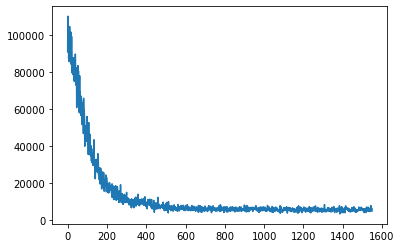

In [481]:
# определить Dataset и DataLoader
class Dataset(torch.utils.data.Dataset):
  def __init__(self, inp, out):
        self.inp = inp
        self.out = out

  def __len__(self):
        return len(self.inp)

  def __getitem__(self, index):
        # Select sample
        input_ = self.inp[index]
        output_ = self.out[index]

        return input_, output_
    
training_set = Dataset(X_train, y_train)

batch_size = 100
training_generator = torch.utils.data.DataLoader(training_set, shuffle=True, batch_size=batch_size, drop_last=True)



# определить структуру нейронной сети
model = nn.Sequential(
        nn.Linear(1,10),
        nn.Tanh(),
        nn.Linear(10,1)
)


# определить функцию ошибки, скорость апдейтов модели и способ оптимизации
learning_rate = 1e-1
optimiz = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()


# тренировать сетку на датасете
num_ep = 5
# Определим очередь (для компактной визуализации)
epochs_tdqm = tqdm(range(num_ep), desc="Loss")
# Будем сохранять ошибки
total_loss = [] 
# собственно цикл тренировки
for epoch in epochs_tdqm:

    #пройдемся по всем батчам из датасета
    for minibatch, labels in training_generator:
    
        minibatch = minibatch.float()
        
        # обнулим градиент
        model.zero_grad()
        
        # forward path: сделаем прогноз
        prediction = model(minibatch)
        
        # backward pass: посчитаем ошибку
        loss = loss_function(prediction, labels.float())
        loss.backward()
        optimiz.step()
        
        # сохраним ошибку
        epochs_tdqm.set_description("(Loss=%g)" % round(loss.item(), 4))
        total_loss.append(loss.detach().numpy())
        
plt.plot(total_loss)
plt.show()

The parameters I decided to use relying on eyes:

batch_size = 100, larning rate = 0.1, number of epoches = 5
model: 1 linear 10 --> tanh --> 10 linear 1

###### Step 2b. Overfitting & R2_test_dataset

In [482]:
# define validation dataset
val_set = Dataset(X_val, y_val)
validation_generator = torch.utils.data.DataLoader(val_set,shuffle=True, batch_size=batch_size, drop_last=True)
X_v = torch.tensor(X_val)

# apply on validation dataset
y_pred = model(X_v.float()).detach().numpy()
print('r2_score on the validation data: %.2f'
      % r2_score(y_val, y_pred))

# apply on the train dataset
X_t = torch.tensor(X_train)
y_pred = model(X_t.float()).detach().numpy()
print('r2_score on the train data: %.2f'
      % r2_score(y_train, y_pred))

# estimate on the test dataset
test_set = Dataset(X_test, y_test)
test_generator = torch.utils.data.DataLoader(test_set)
X_test = torch.tensor(X_test)
y_pred = model(X_test.float()).detach().numpy()
print('r2_score on the test data: %.2f'
      % r2_score(y_test, y_pred))
R2_neural = r2_score(y_test, y_pred)

r2_score on the validation data: 0.26
r2_score on the train data: 0.38
r2_score on the test data: 0.21


#### Step 3. Polynomial regression

###### Step 3a. Choice of polynomial degree

In [483]:
deg=[]
r2=[]

for i in range(1,15):
    deg.append(i)
    polyreg = make_pipeline(
        PolynomialFeatures(degree=i),
        LinearRegression()
        ) 
    polyreg.fit(X_train, y_train)
    y_pred = polyreg.predict(X_val)
    r2.append(r2_score(y_val, y_pred))
    
new_df = pd.DataFrame() #save metric in df
new_df['deg'] = deg
new_df['r2'] = r2
new_df[new_df['r2']==new_df['r2'].max()]

deg        r2
1    2  0.404938

n = 2 is our choice

###### Step 3b. Overfitting & R2_test_dataset

In [484]:
polyreg = make_pipeline(
        PolynomialFeatures(degree=2),
        LinearRegression()
        ) 
polyreg.fit(X_train, y_train)


y_pred = polyreg.predict(X_val)
print('R2 on the validation dataset:', r2_score(y_val, y_pred))


y_pred = polyreg.predict(X_train)
print('R2 on the train dataset:', r2_score(y_train, y_pred))


y_pred = polyreg.predict(X_test)
print('R2 on the test dataset:', r2_score(y_test, y_pred))

R2_polynom = r2_score(y_test, y_pred)

R2 on the validation dataset: 0.40493766301831446
R2 on the train dataset: 0.4684948955307474
R2 on the test dataset: 0.313683477879071


#### Step 4. K-nearest neighbors

###### Step 4a. Choice of K

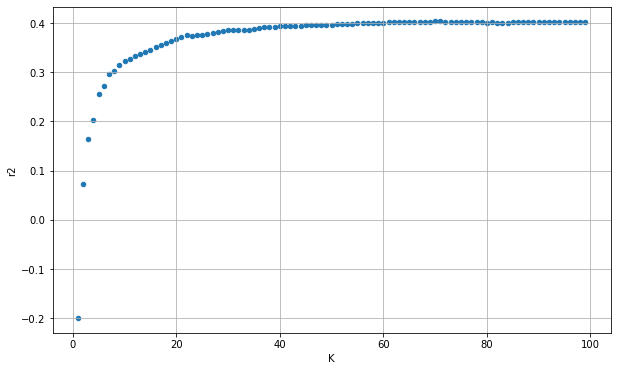

In [485]:
# K-nearest neighbors 
K=[]
r2=[]

for i in range(1,100):
    K.append(i)
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, np.ravel(y_train))
    y_pred = knn.predict(X_val)
    r2.append(r2_score(y_val, y_pred))
    
new_df = pd.DataFrame() #save metric in df
new_df['K'] = K
new_df['r2'] = r2

new_df.plot.scatter('K', 'r2', figsize=(10,6))
plt.grid()

K = 40 is chosen here

###### Step 4b. Overfitting & R2_test_dataset

In [486]:
knn = KNeighborsRegressor(n_neighbors=40)
knn.fit(X_train, y_train)


y_pred = knn.predict(X_val)
print('R2 on the validation dataset:', r2_score(y_val, y_pred))


y_pred = knn.predict(X_train)
print('R2 on the train dataset:', r2_score(y_train, y_pred))


y_pred = knn.predict(X_test)
print('R2 on the test dataset:', r2_score(y_test, y_pred))

R2_neighbor = r2_score(y_test, y_pred)

R2 on the validation dataset: 0.39317413298971415
R2 on the train dataset: 0.48763648819423
R2 on the test dataset: 0.28992748719559824


#### Step 5. Comparison

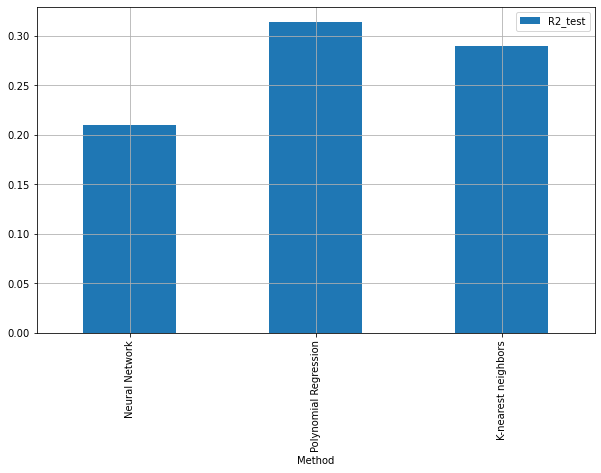

In [487]:
df_fig = pd.DataFrame({'Method': ['Neural Network', 'Polynomial Regression', 'K-nearest neighbors'], 'R2_test': [R2_neural, R2_polynom, R2_neighbor]})
df_fig.plot.bar(x='Method', y='R2_test',figsize=(10,6))
plt.grid()

Again the difference is not so drastic, but still polynomial regression wins. I would say the reason is we can expect regular parametric dependence of Load vs Temperature. Relying on common sense Load should definitely increase if Temperature decrease and vice versa. The maximums of Load kinetic should match the minimum of Temperature kinetic. This strong functional dependence must be expressed in some elementary function behavour. Linear approximation is the simplest one and maybe can be the first suggestion, but our calculations show pretty well that quadratic function (also rather simple) is really good candidate for the right functional dependence we are looking for. 

## Задание 4: Проанализировать какой метод лучше работает в каких обстоятельствах  (10 балов)

In [488]:
# На основе всех результатов этого курса написать рассуждения на тему "В каких случаях лучше использовать нейронные сетки, а когда - классические методы?"

Deep learning is right choice for the big data case. If you have reasonably small datasets classical ML methods is what should be used. Of course what is big and what is small is always the question but that can be solved practically also considering time-consummation of the problem. Sometimes choice of the method becomes easier if  one knows some specifities of data like presence of outliers, data gaps. In all datasets we used during the course the size of data was moderately small so we couldn't see significant advantage of the deep learning approach, but still we saw some regularities. For example, we saw (1) how structure of the model correlates with dataset size: complex structure of the DL model on small dataset gives large overfitting effect, (2) how right choice of parameters can improve metrics and find the balance between the overfitting and underfitting.

Regarding the classical methods, the reasonings about the choice between K-neighbors and PolyRegression were written in the hometask two. Again it seems to me if it's not time consuming the best thing to do is to check several models you expect give you good results. The criterion of practice is the most robust but requires rather long time and/or experience of working with ML methods.

## Задание 5 (допольнительное): Применить методы на ваших данных

In [489]:
# Это задание не обязательное и за него не будет баллов, оно для тех, кто хочет с этим поэкспериментировать